In [53]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [54]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [55]:
#base_dir = "/content/drive/My Drive/Midi_Deep_Composer"
directory = os.path.join(base_dir, "midi/Guitar_Sor")

In [56]:
instru = instrument.Guitar()

In [57]:
notes = []
durations = []
track = 0
scale = 1

for i, file in enumerate(os.listdir(directory)):
    midi_part = converter.parse(os.path.join(directory, file))
    # Use only first track
    midi_part = midi_part[track]
    notes_to_parse = None
    # Parse the midi file by the notes/chords it contains
    notes_to_parse = midi_part.flat.notesAndRests
    for elem in notes_to_parse:
        if isinstance(elem, note.Note):
            notes.append([str(elem.pitch)])
        elif isinstance(elem, chord.Chord):
            notes.append([str(n.nameWithOctave) for n in elem.pitches])
        elif isinstance(elem, note.Rest):
            notes.append([elem.name])
        durations.append(elem.quarterLength)
    
    notes.append(["rest"])
    durations.append(1.0)
    print("Song %s Loaded" % file)
                
print("DONE LOADING SONGS")    
# Get all pitch names
np_notes = np.array(notes)
np_notes = np_notes.flatten()
notes_vocab = []
for item in np_notes:
    if len(item) > 1 and item != "rest":
        notes_vocab.append(",".join([note for note in item]))
    else:
        notes_vocab.append(item[0])
notes_vocab = sorted(set(notes_vocab))
# Get all durations
durations_vocab = []
durations_vocab = sorted(set(durations))

notes_vocab_len = len(notes_vocab)
durations_vocab_len = len(durations_vocab)
number_notes = len(notes)
print(notes_vocab_len, durations_vocab_len, number_notes)
print(notes_vocab, notes)
durations_vocab_len = len(durations_vocab)
print(durations_vocab, durations)

Song Sor_Study_no1.mid Loaded
Song Sor_Study_no10.mid Loaded
Song Sor_Study_no11.mid Loaded
Song Sor_Study_no12.mid Loaded
Song Sor_Study_no13.mid Loaded
Song Sor_Study_no14.mid Loaded
Song Sor_Study_no15.mid Loaded
Song Sor_Study_no16.mid Loaded
Song Sor_Study_no17.mid Loaded
Song Sor_Study_no18.mid Loaded
Song Sor_Study_no19.mid Loaded
Song Sor_Study_no2.mid Loaded
Song Sor_Study_no20a.mid Loaded
Song Sor_Study_no3.mid Loaded
Song Sor_Study_no4.mid Loaded
Song Sor_Study_no5.mid Loaded
Song Sor_Study_no6.mid Loaded
Song Sor_Study_no7.mid Loaded
Song Sor_Study_no8.mid Loaded
Song Sor_Study_no9.mid Loaded
DONE LOADING SONGS
387 21 6892
['A2', 'A3', 'A3,A2', 'A3,B2', 'A3,B3', 'A3,C#3', 'A3,C3,A2', 'A3,C4', 'A3,C4,F#4', 'A3,C4,G4', 'A3,D3', 'A3,D4,F#4', 'A3,E-3,F2', 'A3,E3', 'A3,E3,C3', 'A3,F#3', 'A3,F#3,B2', 'A3,F3', 'A3,F4', 'A4', 'A4,A2', 'A4,A3', 'A4,B3', 'A4,C#4', 'A4,C#4,A2', 'A4,C#4,A3', 'A4,C#4,A3,A2', 'A4,C4', 'A4,C4,A2', 'A4,C4,E-3', 'A4,C5', 'A4,D4', 'A4,E-4,C4', 'A4,E-4,C4,F3'

In [58]:
# turn notes to integers:
cat_notes = []
for elem in notes:
    int_note = notes_vocab.index(",".join(elem))
    cat = np.zeros((len(notes_vocab)))
    cat[int_note] = 1
    cat_notes.append(cat)
cat_durations = []
for elem in durations:
    int_duration = durations_vocab.index(elem)
    cat = np.zeros((len(durations_vocab)))
    cat[int_duration] = 1
    cat_durations.append(cat)

# merge
x = [np.array(cat_notes), np.array(cat_durations)]

In [59]:
seq_len = 32 * scale
batch_size = 32
split = int(0.8 * len(x))


class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0]) // self.batch_size - 1
    def __getitem__(self, idx):
        X_note = []
        X_duration = []
        Y_note = []
        Y_duration = []
        for i in range(self.batch_size):
            X_note.append(self.x[0][idx+i : idx+i + seq_len])
            X_duration.append(self.x[1][idx+i : idx+i + seq_len])
            Y_note.append(self.x[0][idx+i + seq_len])
            Y_duration.append(self.x[1][idx+i + seq_len])
        return [np.array(X_note), np.array(X_duration)], [np.array(Y_note), np.array(Y_duration)]
data_gen = dataGenerator(x, batch_size)

In [60]:
print(x[0].shape, x[1].shape)

(6892, 387) (6892, 21)


In [61]:
# Build Model

In [62]:
K.clear_session()

in_note = Input(shape=(seq_len, len(notes_vocab)))
x1 = Bidirectional(LSTM(32 * scale))(in_note)

in_duration = Input(shape=(seq_len, len(durations_vocab)))
x2 = Bidirectional(LSTM(32 * scale))(in_duration)

concat = Concatenate()([x1, x2])
shared = Dense(64 * scale, activation='relu')(concat)

out_note = Dense(len(notes_vocab), activation='softmax')(shared)
out_duration = Dense(len(durations_vocab), activation='softmax')(shared)

model = Model(inputs=[in_note, in_duration], outputs=[out_note, out_duration])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 387)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 21)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           107520      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 64)           13824       input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [63]:
#save best model if model improved
model_name = "Sor.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [64]:
h = model.fit_generator(data_gen, epochs = 10, callbacks=[best_checkpoint])

Epoch 1/10
214/214 [==============================] - 10s 46ms/step - loss: 4.4441 - dense_2_loss: 2.8481 - dense_3_loss: 1.5960 - dense_2_acc: 0.2653 - dense_3_acc: 0.4968
Epoch 2/10
  3/214 [..............................] - ETA: 8s - loss: 2.8453 - dense_2_loss: 1.5331 - dense_3_loss: 1.3122 - dense_2_acc: 0.3958 - dense_3_acc: 0.4583

c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


214/214 [==============================] - 8s 37ms/step - loss: 2.6816 - dense_2_loss: 1.9409 - dense_3_loss: 0.7407 - dense_2_acc: 0.3794 - dense_3_acc: 0.7846
Epoch 3/10
214/214 [==============================] - 8s 39ms/step - loss: 1.8421 - dense_2_loss: 1.5479 - dense_3_loss: 0.2942 - dense_2_acc: 0.5327 - dense_3_acc: 0.9140
Epoch 4/10
214/214 [==============================] - 9s 42ms/step - loss: 1.2609 - dense_2_loss: 1.0809 - dense_3_loss: 0.1800 - dense_2_acc: 0.6675 - dense_3_acc: 0.9464
Epoch 5/10
214/214 [==============================] - 9s 42ms/step - loss: 0.8582 - dense_2_loss: 0.7488 - dense_3_loss: 0.1094 - dense_2_acc: 0.7577 - dense_3_acc: 0.9701
Epoch 6/10
214/214 [==============================] - 9s 41ms/step - loss: 0.5833 - dense_2_loss: 0.5177 - dense_3_loss: 0.0655 - dense_2_acc: 0.8468 - dense_3_acc: 0.9879
Epoch 7/10
214/214 [==============================] - 9s 43ms/step - loss: 0.3998 - dense_2_loss: 0.3538 - dense_3_loss: 0.0460 - dense_2_acc: 0.9138 -

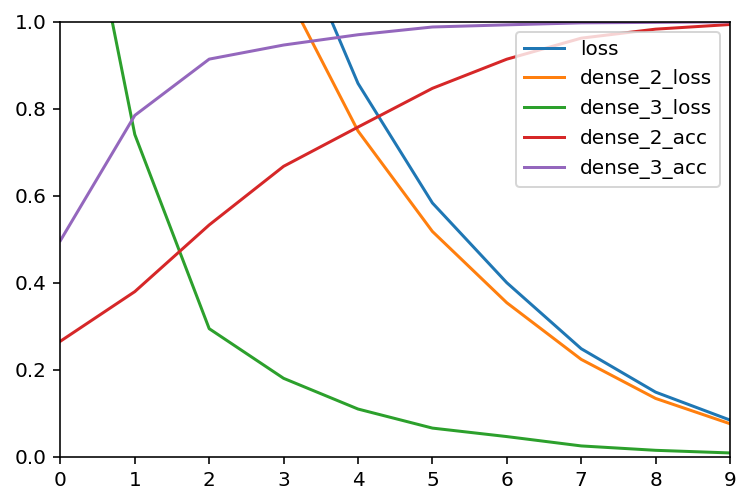

In [65]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [0]:
# Load / save

In [37]:
#model.save(os.path.join(base_dir, "Sor.h5"))
model = load_model(os.path.join(base_dir, "Sor.h5"))

In [71]:
# Build seed
idx = 42
x_test, _ = data_gen[idx]
x_test = [x_test[0][0], x_test[1][0]]
x_test_stream = stream.Stream()

for i in range(seq_len):
    str_note = notes_vocab[np.argmax(x_test[0][i])]
    duration = durations_vocab[np.argmax(x_test[1][i])]
    if len(str_note.split(",")) > 1:
        _chord = chord.Chord(str_note.split(","))
        _chord.quarterLength = duration
        x_test_stream.append(_chord)
    else:
        if str_note != "rest":
            _note = note.Note(str_note)
            _note.quarterLength = duration
            x_test_stream.append(_note)
        else:
            _rest = note.Rest()
            _rest.quarterLength = duration
            x_test_stream.append(_rest)
x_test_stream.insert(0, instru)
print(len(x_test[0]), [(np.argmax(x_test[0][i]), np.argmax(x_test[1][i])) for i, _ in enumerate(x_test[0])])

32 [(357, 10), (357, 0), (290, 14), (386, 3), (224, 10), (163, 10), (19, 10), (357, 10), (357, 0), (290, 14), (386, 3), (226, 10), (224, 10), (163, 10), (127, 10), (89, 10), (133, 10), (174, 10), (242, 15), (386, 10), (133, 10), (173, 10), (242, 10), (300, 18), (179, 10), (242, 10), (300, 10), (378, 18), (244, 10), (303, 10), (42, 10), (242, 10)]


In [72]:
# make seq_len predictions from seed
preds = []
x = x_test

for i in range(seq_len):
    _note, _duration = model.predict([np.array([x[0]]), np.array([x[1]])])
    
    cat_note = np.zeros((len(notes_vocab)))
    _note = np.argmax(_note)
    cat_note[_note] = 1
    
    cat_duration = np.zeros((len(durations_vocab)))
    _duration = np.argmax(_duration)
    cat_duration[_duration] = 1
    
    x[0] = x[0][1:]
    x[0] = list(x[0]) + [cat_note]
    x[1] = x[1][1:]
    x[1] = list(x[1]) + [cat_duration]
    preds.append((cat_note, cat_duration))
print(len(preds), [(np.argmax(pred[0]), np.argmax(pred[1])) for pred in preds])

32 [(300, 10), (173, 10), (127, 10), (224, 10), (272, 10), (357, 10), (163, 10), (226, 10), (290, 10), (127, 10), (163, 10), (224, 10), (69, 10), (106, 10), (163, 10), (1, 10), (69, 10), (139, 10), (166, 10), (83, 10), (127, 10), (386, 10), (27, 15), (357, 10), (357, 15), (290, 10), (290, 15), (224, 10), (224, 15), (163, 10), (163, 15), (127, 10)]


In [73]:
# Build predicted stream
y_test_stream = stream.Stream()
for i in range(len(preds)):
    str_note = notes_vocab[np.argmax(preds[i][0])]
    duration = durations_vocab[np.argmax(preds[i][1])]
    if len(str_note.split(",")) > 1:
        _chord = chord.Chord(str_note.split(","))
        _chord.quarterLength = duration
        y_test_stream.append(_chord)
    else:
        if str_note != "rest":
            _note = note.Note(str_note)
            _note.quarterLength = duration
            y_test_stream.append(_note)
        else:
            _rest = note.Rest()
            _rest.quarterLength = duration
            y_test_stream.append(_rest)
y_test_stream.insert(0, instru)

In [ ]:
# play seed
x_test_stream.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_test_stream)
sp.play()

In [ ]:
# play generated music
y_test_stream.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_test_stream)
sp.play()